# 3D Brain MRI Segmentation 

**Targets:** cortex (3, 42), M1 (8), DLPFC (5).

---

## Label Codes 
Label codes: cortex: 3, 42; M1: 8; DLPFC: 5

---

In [2]:
# Imports
import os
import numpy as np
import torch
import torch.nn as nn
from fastai.vision.all import *
from fastai.callback.all import *
import monai
from monai.networks.nets import UNet, BasicUNet, resnet
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd, ScaleIntensityd, ToTensord
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import random


## Labels

In [3]:
label_codes = {
    'background': 0,
    'cortex_left': 3,
    'cortex_right': 42,
    'M1': 8,
    'DLPFC': 5,
}
targets = ['cortex_left', 'cortex_right', 'M1', 'DLPFC']


## Data Loading

In [4]:
def load_nifti(path):
    img = nib.load(str(path))
    data = img.get_fdata()
    return data

def extract_target_mask(mask, label_codes, targets):
    out = np.zeros_like(mask, dtype=np.uint8)
    for i, t in enumerate(targets, 1):
        out[np.isin(mask, label_codes[t])] = i
    return out

def load_image_and_mask(img_path, mask_path, label_codes, targets):
    img = load_nifti(img_path)
    mask = load_nifti(mask_path)
    mask = extract_target_mask(mask, label_codes, targets)
    return img, mask


## Preprocessing
- Z-score normalization
- N4ITK, histogram equalization.


In [5]:
def zscore_normalize(img):
    img = img.astype(np.float32)
    mean = img.mean()
    std = img.std()
    return (img - mean) / (std + 1e-8)


## Dataset Paths


In [11]:
IMG_DIR = Path('../data/preprocessed')
MASK_DIR = Path('../data/classical_segmented')
img_files = sorted(list(IMG_DIR.glob('IBSR_*_zscore.nii.gz')))
mask_files = sorted(list(MASK_DIR.glob('IBSR_*_zscore.nii_otsu.nii.gz'))
print(f'Found {len(img_files)} images and {len(mask_files)} masks')


Found 4 images and 4 masks


## DataBlock & Dataloaders (fastai)


In [24]:
from fastai.vision.all import Tensor, show_image

def show_3d_tensor(x, ctx=None, title=None, **kwargs):
    arr = x
    if hasattr(arr, 'cpu'): arr = arr.cpu()
    arr = arr.squeeze()
    print(f"Shape to show: {arr.shape}") 

    # Handle (D, H, W), (1, D, H, W), (C, D, H, W), (H, W)
    if arr.ndim == 3:
        # (D, H, W): show middle slice along depth
        slice_idx = arr.shape[0] // 2
        img = arr[slice_idx]
    elif arr.ndim == 4:
        # (C, D, H, W): show first channel, middle slice
        slice_idx = arr.shape[1] // 2
        img = arr[0, slice_idx]
    elif arr.ndim == 2:
        img = arr
    else:
        raise ValueError(f"Unexpected tensor shape for 3D image: {arr.shape}")
    return show_image(img, ctx=ctx, title=title, **kwargs)

Tensor.show = show_3d_tensor

Shape to show: torch.Size([256, 256, 128])
Shape to show: torch.Size([256, 256, 128])


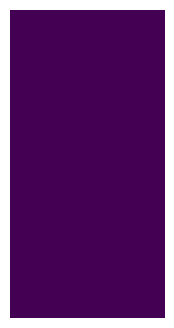

In [29]:
def get_x(i): return zscore_normalize(load_nifti(img_files[i]))
def get_y(i): return extract_target_mask(load_nifti(mask_files[i]), label_codes, targets)

class ToTensor3D(Transform):
    def encodes(self, x):
        t = torch.tensor(x, dtype=torch.float32)
        if t.ndim == 3:
            t = t.unsqueeze(0)  # (D, H, W) -> (1, D, H, W)
        elif t.ndim == 4 and t.shape[0] == 1:
            pass  # already (1, D, H, W)
        elif t.ndim == 4 and t.shape[-1] == 1:
            t = t.permute(3, 0, 1, 2)  # (D, H, W, 1) -> (1, D, H, W)
        else:
            raise ValueError(f"Unexpected image shape: {t.shape}")
        return t
    def decodes(self, x): return x.squeeze()

class ToTensorMask3D(Transform):
    def encodes(self, x): return torch.tensor(x, dtype=torch.long)
    def decodes(self, x): return x

dblock = DataBlock(
    blocks=(TransformBlock(type_tfms=ToTensor3D()), TransformBlock(type_tfms=ToTensorMask3D())),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(seed=42),
)
dls = dblock.dataloaders(range(len(img_files)), bs=1)
dls.show_batch(max_n=1)


## Model Definitions (MONAI)
- 3D U-Net
- 3D ResNet


In [30]:
n_classes = len(targets) + 1  # background + targets

unet3d = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=n_classes,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
   num_res_units=2,
    norm='batch'
    )

resnet3d = resnet.resnet10(spatial_dims=3, n_input_channels=1, num_classes=n_classes)


## fastai Learner

In [31]:
loss_func = nn.CrossEntropyLoss()
metrics = [DiceMulti(), JaccardCoeffMulti()]

learn_unet = Learner(dls, unet3d, loss_func=loss_func, metrics=metrics)
learn_resnet = Learner(dls, resnet3d, loss_func=loss_func, metrics=metrics)


## Training

In [28]:
# Train U-Net
learn_unet.fine_tune(10)
# Train ResNet
learn_resnet.fine_tune(10)


epoch,train_loss,valid_loss,dice_multi,jaccard_coeff_multi,time


Im not being able to run this, it is giving me an error on the sizing for some reason. Might have to pivot...

## Inference

## Metrics & Evaluation


## Visualization